In [120]:
import os.path

import torch
import torchvision

In [121]:
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [122]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "data/",
        train=False,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.1307,), (0.3081,)),
            ]
        ),
    ),
    batch_size=batch_size_test,
    shuffle=True,
)

In [123]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

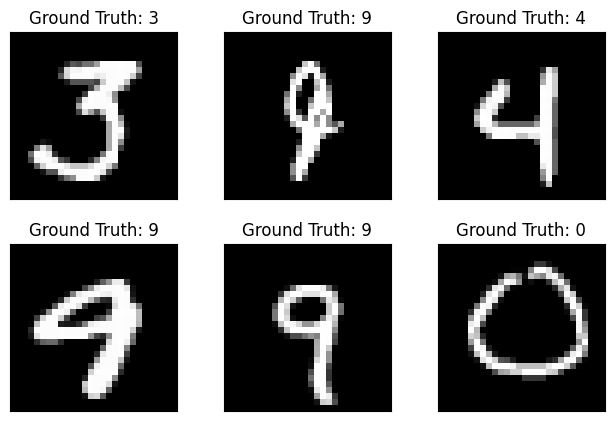

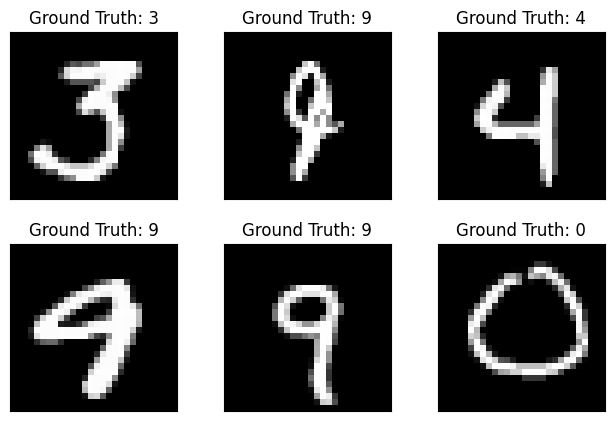

In [124]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [125]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(H, D_out)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x

In [126]:
# D_in is input dimension; H is hidden dimension; D_out is output dimension.
D_in, H, D_out = 28 * 28, 100, 10

In [127]:
criterion = torch.nn.NLLLoss()

In [128]:
def train(epoch: int, device: str):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset))
            )
            torch.save(model.state_dict(), "results/model.pth")
            torch.save(optimizer.state_dict(), "results/optimizer.pth")

In [129]:
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(
        "\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

In [130]:
import os

if not os.path.exists("results/"):
    print("Creating directory")
    os.makedirs("results")

Will train on ['cpu', 'cuda']
Training on device cpu

Test set: Avg. loss: 0.0023, Accuracy: 1056/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302703
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.662547
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.390067
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.480202
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.395925
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.339681
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.357948
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.486148
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.131784
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.174788

Test set: Avg. loss: 0.0003, Accuracy: 9260/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.403007
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.388448
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.225894
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.129621
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.386915
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.421109
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.

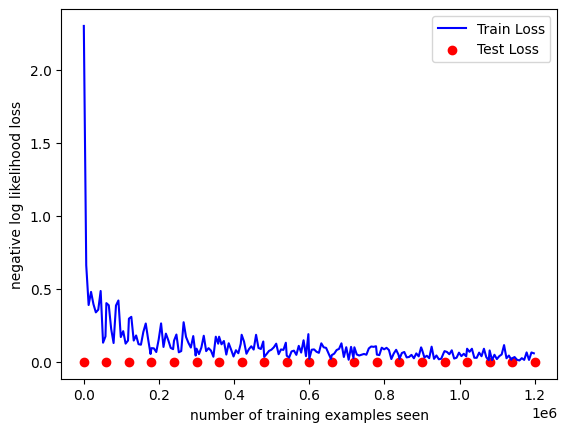

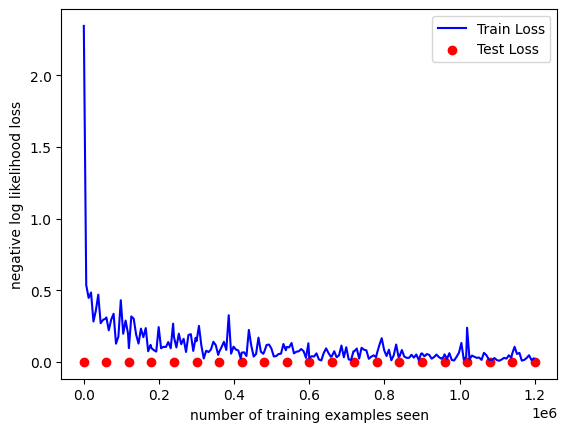

In [131]:
import time

from torch import optim


devices = ["cpu"]
if torch.cuda.is_available():
    devices.append("cuda")

print(f"Will train on {devices}")

for device in devices:
    print(f"Training on device {device}")

    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

    model = TwoLayerNet(D_in, H, D_out).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    test()
    start_time = time.time()
    for epoch in range(1, n_epochs + 1):
        train(epoch, device)
        test()
    end_time = time.time()

    fig = plt.figure()
    plt.plot(train_counter, train_losses, color="blue")
    plt.scatter(test_counter, test_losses, color="red")
    plt.legend(["Train Loss", "Test Loss"], loc="upper right")
    plt.xlabel("number of training examples seen")
    plt.ylabel("negative log likelihood loss")
    fig.show()

    print(f"Training on the {device} took {end_time - start_time} seconds")